In [1]:
%run forward_simulation.ipynb
%run pid_controller.ipynb

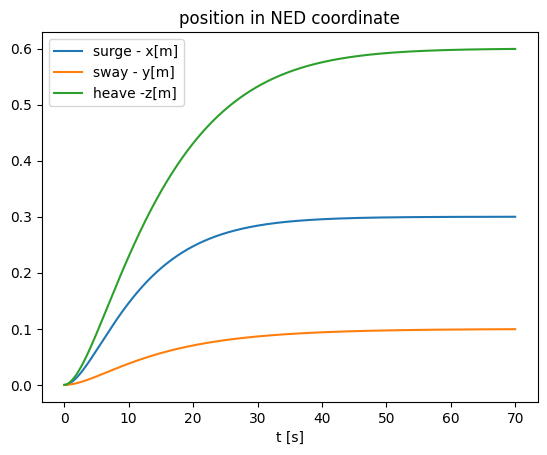

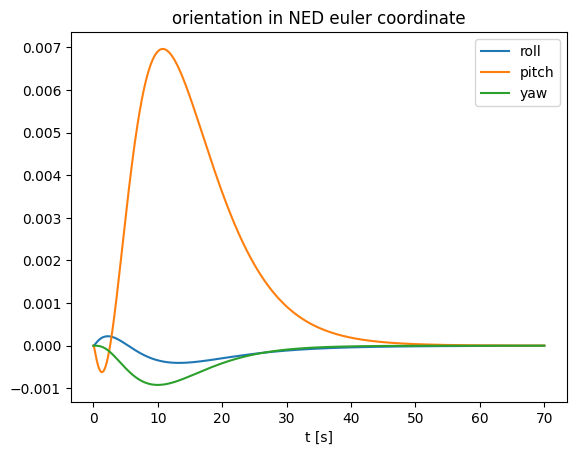

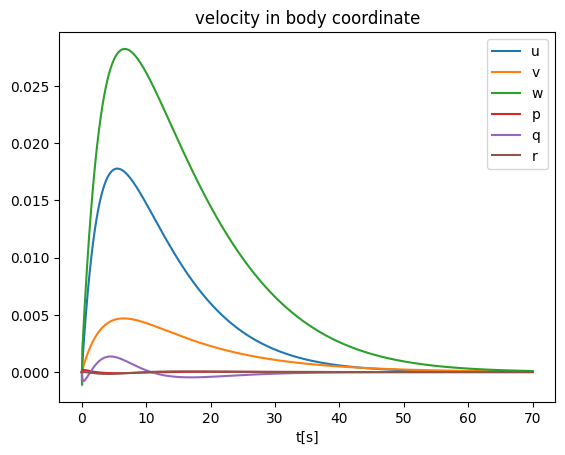

In [2]:
uv_sim = Fsim(sim_x, pid_control, sim_p, dt)
cl_sys = Function('cl_system', [sim_x, nd, Kp, Ki, Kd, sim_p, dt, sum_e_buffer], [uv_sim])

cl_sim = cl_sys.mapaccum(blue.N)

uv_desired = np.array([0.3, 0.1, 0.6, 0.0, 0.0, 0.0])

x0 = np.array([0.0, 0.0, 0.0, 0, 0, 0, 0, 0, 0, 0, 0, 0]) #x y z r p y u v w p q r
sebuffer_ = np.array([0,0,0,0,0,0])

res = cl_sim(x0, uv_desired, blue.kp, blue.ki, blue.kd, blue.sim_params, blue.dt_s, sebuffer_)

res.T

t = np.linspace(0, blue.T, blue.N+1)

# Create a figure and plot the data
plt.figure()
plt.plot(t, np.concatenate((np.array(x0).reshape((12,1)), res.toarray()), axis=1)[0:3,:].T)
plt.legend(['surge - x[m]', 'sway - y[m]', 'heave -z[m]'])
plt.title("position in NED coordinate")
plt.xlabel('t [s]')

plt.figure()
plt.plot(t, np.concatenate((np.array(x0).reshape((12,1)), res.toarray()), axis=1)[3:6,:].T)
plt.legend(['roll', 'pitch', 'yaw'])
plt.title("orientation in NED euler coordinate")
plt.xlabel('t [s]')

plt.figure()
plt.plot(t, np.concatenate((np.array(x0).reshape((12,1)), res.toarray()), axis=1)[6::,:].T)
plt.legend(['u', 'v', 'w', 'p', 'q', 'r'])
plt.xlabel('t[s]')
plt.title("velocity in body coordinate")
plt.show()